Filename: LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    289   435R x 3C   [D, D, D]   
  2  SCI           1 ImageHDU       279   (435, 31)   float64   
  3  WHT           1 ImageHDU       279   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       279   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, D, D]   
None
Filename: LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SPEC1D        1 BinTableHDU    304   435R x 4C   [D, D, D, D]   
  2  SCI           1 ImageHDU       291   (435, 31)   float64   
  3  WHT           1 ImageHDU       291   (435, 31)   float64   
  4  PROFILE       1 ImageHDU       291   (435, 31)   float64   
  5  PROF1D        1 BinTableHDU     25   31R x 3C   [D, 

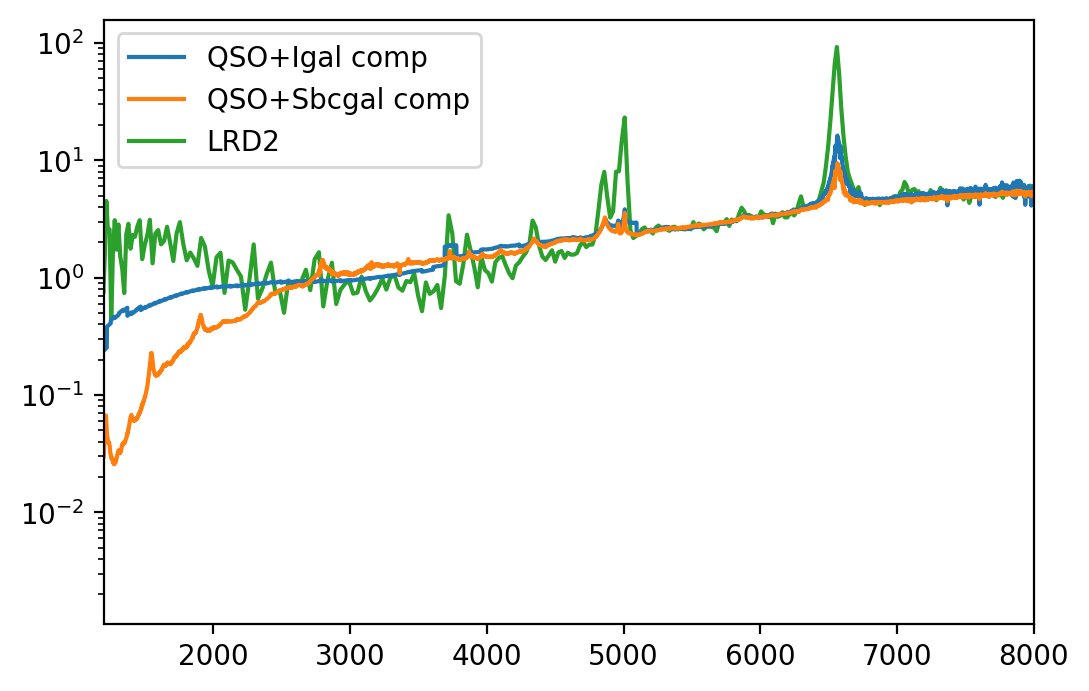

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from spectres import spectres
import scipy.integrate as spi
from astropy.io import fits

#SMC extinction parameters
ai = np.array([185.,27.,0.005,0.010,0.012,0.030])
wli = np.array([0.042,0.08,0.22,9.7,18.,25.])
bi = np.array([90.,5.50,-1.95,-1.95,-1.80,0.0])
ni = np.array([2.0,4.0,2.0,2.0,2.0,2.0])
Ki = np.array([2.89,0.91,0.02,1.55,1.72,1.89])


#Read LRD spectra
z = 3.438
#from 1.1 to 1.6
HDU = fits.open('LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd1 = spec1d.wave*10000./(1+z)
spec_lrd1 = spec1d.flux*(wave_lrd1/10000.)**2
z = 5.05
#from 1.9 to 2.5
HDU = fits.open('LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd2 = spec1d.wave*10000./(1+z)
spec_lrd2 = spec1d.flux/(wave_lrd2/10000.)**2
z=4.53
#from 1.7 to 2.3
HDU = fits.open('LRD/macsj0647-v2_prism-clear_1433_1045.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd3 = spec1d.wave*10000./(1+z)
spec_lrd3 = spec1d.flux*(wave_lrd3/10000.)**2

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]

#Read galaxy templates
tab = np.loadtxt('JaffetGaltemplates/lrt_templates.dat')
wave_jaffet = tab[:,0]*10000.
spec_E = tab[:,3]/wave_jaffet**2
spec_Sbc = tab[:,4]/wave_jaffet**2
spec_I = tab[:,5]/wave_jaffet**2

#Rebin to quasar wavelength grid
spec_I_rebin = spectres(wave_qso,wave_jaffet,spec_I)
spec_Sbc_rebin = spectres(wave_qso,wave_jaffet,spec_Sbc)

AVqso = 5
ABqso = AVqso*4.1/3.1

AVqso2 = 1.5
ABqso2 = AVqso2*4.1/3.1

#Redden the qso template with I gal
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model_qso = 10**(-0.4*Alambda)*spec_qso

#Redden the qso template with Sbc gal
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda2 = Alambda*ABqso2
model_qso2 = 10**(-0.4*Alambda2)*spec_qso

AV_Igal = 0.5
AB_Igal = AV_Igal*4.1/3.1

#Redden the I gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda_I = Alambda*AB_Igal
spec_I_rebin = 10**(-0.4*Alambda_I)*spec_I_rebin

AV_Sbcgal = 3
AB_Sbcgal = AV_Sbcgal*4.1/3.1

#Redden the Sbc gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda_Sbc = Alambda*AB_Sbcgal
spec_Sbc_rebin = 10**(-0.4*Alambda_Sbc)*spec_Sbc_rebin

#Normalise with I gal
specfilt = np.nonzero((wave_lrd2 > 5200) & (wave_lrd2 < 5500))
normspec = np.mean(spec_lrd2[specfilt])
modelfilt = np.nonzero((wave_qso > 5200) & (wave_qso < 5500))
normqso = np.mean(model_qso[modelfilt])
normgal = np.mean(spec_I_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model_Igal = (model_qso*factorqso+spec_I_rebin*factorgal)/2.

#Normalise with Sbc gal
specfilt = np.nonzero((wave_lrd2 > 5200) & (wave_lrd2 < 5500))
normspec = np.mean(spec_lrd2[specfilt])
modelfilt = np.nonzero((wave_qso > 5200) & (wave_qso < 5500))
normqso2 = np.mean(model_qso2[modelfilt])
normgal2 = np.mean(spec_Sbc_rebin[modelfilt])
factorqso2 = normspec/normqso2
factorgal2 = normspec/normgal2
model_Sbcgal = (model_qso2*factorqso2+spec_Sbc_rebin*factorgal2)/2.


#Make plot
plt.figure(dpi=200)
#plt.plot(wave_lrd1,spec_lrd1,zorder=1,label='LRD1')
plt.plot(wave_qso,model_Igal,label='QSO+Igal comp')
plt.plot(wave_qso,model_Sbcgal, label='QSO+Sbcgal comp')
plt.plot(wave_lrd2,spec_lrd2,zorder=1,label='LRD2')
#plt.plot(wave_lrd3,spec_lrd3*10.,zorder=1,label='LRD3')
plt.yscale('log')
plt.legend()
plt.xlim(1200,8000)
plt.show()

#Plot
#spec_qso_gal =  spectres(wave_jaffet,wave_qso,spec_qso)
#plt.figure()
#plt.plot(wave_jaffet, spec_qso_gal, color='b')
#plt.plot(wave_jaffet, spec_I*5000., color='r')
#plt.xlim(1000,25000)
#plt.show()


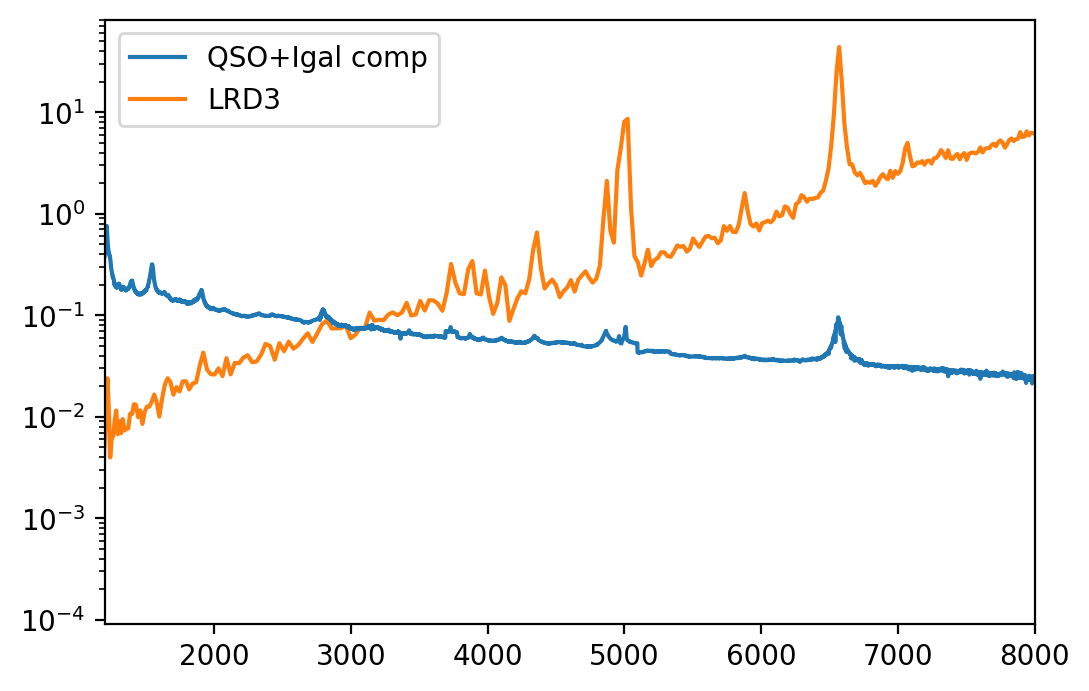

In [2]:
AVqso_I3 = 5
ABqso_I3 = AVqso_I3*4.1/3.1

#Redden the qso template with I gal
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda3=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda3 = Alambda3*ABqso_I3
model_qso3 = 10**(-0.4*Alambda3)*spec_qso

AV_Igal3 = 0.5
AB_Igal3 = AV_Igal3*4.1/3.1

#Redden the I gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda3=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda_I3 = Alambda3*AB_Igal3
spec_I_rebin3 = 10**(-0.4*Alambda_I3)*spec_I_rebin

#Normalise with I gal
specfilt = np.nonzero((wave_lrd3 > 5200) & (wave_lrd3 < 5500))
normspec = np.mean(spec_lrd3[specfilt])
modelfilt = np.nonzero((wave_qso > 5200) & (wave_qso < 5500))
normqso = np.mean(model_qso3[modelfilt])
normgal = np.mean(spec_I_rebin3[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model_Igal3 = (model_qso3*factorqso+spec_I_rebin3*factorgal)/2.



#Make plot
plt.figure(dpi=200)
#plt.plot(wave_lrd1,spec_lrd1,zorder=1,label='LRD1')
plt.plot(wave_qso,model_Igal3,label='QSO+Igal comp')
#plt.plot(wave_qso,model_Sbcgal, label='QSO+Sbcgal comp')
#plt.plot(wave_lrd2,spec_lrd2,zorder=1,label='LRD2')
plt.plot(wave_lrd3,spec_lrd3*10.,zorder=1,label='LRD3')
plt.yscale('log')
plt.legend()
plt.xlim(1200,8000)
plt.show()

# Ny kode rettet for fejl

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from spectres import spectres
import scipy.integrate as spi
from astropy.io import fits

#SMC extinction parameters
ai = np.array([185.,27.,0.005,0.010,0.012,0.030])
wli = np.array([0.042,0.08,0.22,9.7,18.,25.])
bi = np.array([90.,5.50,-1.95,-1.95,-1.80,0.0])
ni = np.array([2.0,4.0,2.0,2.0,2.0,2.0])
Ki = np.array([2.89,0.91,0.02,1.55,1.72,1.89])


#Read LRD spectra
z = 3.438
#from 1.1 to 1.6
HDU = fits.open('LRD/ceers-ddt-v2_prism-clear_2750_1034.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd1 = spec1d.wave*10000./(1+z)
spec_lrd1 = spec1d.flux/(wave_lrd1/10000.)**2
z = 5.05
#from 1.9 to 2.5
HDU = fits.open('LRD/jades-gdn-v2_prism-clear_1181_68797.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd2 = spec1d.wave*10000./(1+z)
spec_lrd2 = spec1d.flux/(wave_lrd2/10000.)**2
z=4.53
#from 1.7 to 2.3
HDU = fits.open('LRD/macsj0647-v2_prism-clear_1433_1045.spec.fits')
print(HDU.info())
hdr = HDU[1].header
spec1d = HDU[1].data
wave_lrd3 = spec1d.wave*10000./(1+z)
spec_lrd3 = spec1d.flux/(wave_lrd3/10000.)**2

#select LRD
wave_lrd = wave_lrd2
spec_lrd = spec_lrd2

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]

#Read galaxy templates
tab = np.loadtxt('JaffetGaltemplates/lrt_templates.dat')
wave_jaffet = tab[:,0]*10000.
spec_E = tab[:,3]/wave_jaffet**2
spec_Sbc = tab[:,4]/wave_jaffet**2
spec_I = tab[:,5]/wave_jaffet**2

#Rebin to quasar wavelength grid
spec_I_rebin = spectres(wave_qso,wave_jaffet,spec_I)
spec_Sbc_rebin = spectres(wave_qso,wave_jaffet,spec_Sbc)
spec_E_rebin = spectres(wave_qso,wave_jaffet,spec_E)
spec_gal_rebin = spec_I_rebin

#LRD1:
#Spec_I
#1/9 weight to gal/qso
#Avqso = 0.0
#Avgal = 0.0
#normalise at 4500-4600 Å
#LRD2:
#Spec_I
#50/50 weight to gal/qso
#Avqso = 5.1
#Avgal = 0.
#normalise at 4500-4600 Å
#LRD3:
#Spec_I
#5/1 weight to gal/qso
#Avqso = 8.5
#Avgal = -0.3
#normalise at 5250-5600 Å


AVqso = 4.5
ABqso = AVqso*4.1/3.1
print(ABqso)

#Redden the qso template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model = 10**(-0.4*Alambda)*spec_qso

AVgal = 0.0
ABgal = AVgal*4.1/3.1

#Redden the gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABgal
spec_gal_rebin = 10**(-0.4*Alambda)*spec_gal_rebin

#Normalise
#specfilt = np.nonzero((wave_lrd > 4500) & (wave_lrd < 4600))
specfilt = np.nonzero((wave_lrd > 5250) & (wave_lrd < 5600))
normspec = np.mean(spec_lrd[specfilt])
#modelfilt = np.nonzero((wave_qso > 4500) & (wave_qso < 4600))
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model[modelfilt])
normgal = np.mean(spec_gal_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model = (3.*model*factorqso+1.*spec_gal_rebin*factorgal)/4.

#Make plot
plt.figure(dpi=200)
plt.plot(wave_qso,model,label='QSO+I-gal Composite model')
#plt.plot(wave_qso,spec_gal_rebin*factorgal, color='green')
plt.plot(wave_lrd,spec_lrd,zorder=1,label='LRD2')
#plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\lambda$ [Å]')
plt.ylabel('Flux density $[erg/s/cm^2/Å]$')
plt.text(5000,10**-1,'$z_{LRD}$=5.05, $A_{B_{QSO}}$=5.95')
plt.legend()
#plt.xlim(1200,12000) # LRD1
plt.xlim(1200,8700) # LRD2
#plt.xlim(1100,9600) #LRD3
plt.ylim(0.01,300)
plt.show()


In [ ]:
#select LRD
wave_lrd = wave_lrd2
spec_lrd = spec_lrd2

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]

#Read galaxy templates
tab = np.loadtxt('JaffetGaltemplates/lrt_templates.dat')
wave_jaffet = tab[:,0]*10000.
spec_E = tab[:,3]/wave_jaffet**2
spec_Sbc = tab[:,4]/wave_jaffet**2
spec_I = tab[:,5]/wave_jaffet**2

#Rebin to quasar wavelength grid
spec_I_rebin = spectres(wave_qso,wave_jaffet,spec_I)
spec_Sbc_rebin = spectres(wave_qso,wave_jaffet,spec_Sbc)
spec_E_rebin = spectres(wave_qso,wave_jaffet,spec_E)
spec_gal_rebin = spec_Sbc_rebin


AVqso = 5.5
ABqso = AVqso*4.1/3.1
print(ABqso)

#Redden the qso template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model = 10**(-0.4*Alambda)*spec_qso

AVgal = 0
ABgal = AVgal*4.1/3.1

#Redden the gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABgal
spec_gal_rebin = 10**(-0.4*Alambda)*spec_gal_rebin

#Normalise
#specfilt = np.nonzero((wave_lrd > 4500) & (wave_lrd < 4600))
specfilt = np.nonzero((wave_lrd > 5250) & (wave_lrd < 5600))
normspec = np.mean(spec_lrd[specfilt])
#modelfilt = np.nonzero((wave_qso > 4500) & (wave_qso < 4600))
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model[modelfilt])
normgal = np.mean(spec_gal_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model = (1.3*model*factorqso+2.7*spec_gal_rebin*factorgal)/4.

#Make plot
plt.figure(dpi=150)
plt.plot(wave_qso,model,label='QSO+Sbc-gal Composite model')
#plt.plot(wave_qso,spec_gal_rebin*factorgal, color='green')
plt.plot(wave_lrd,spec_lrd,zorder=1,label='LRD2')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.xlim(1200,12000) # LRD1
plt.xlim(1200,8700) # LRD2
#plt.xlim(1100,9600) #LRD3
plt.ylim(0.01,300)
plt.show()


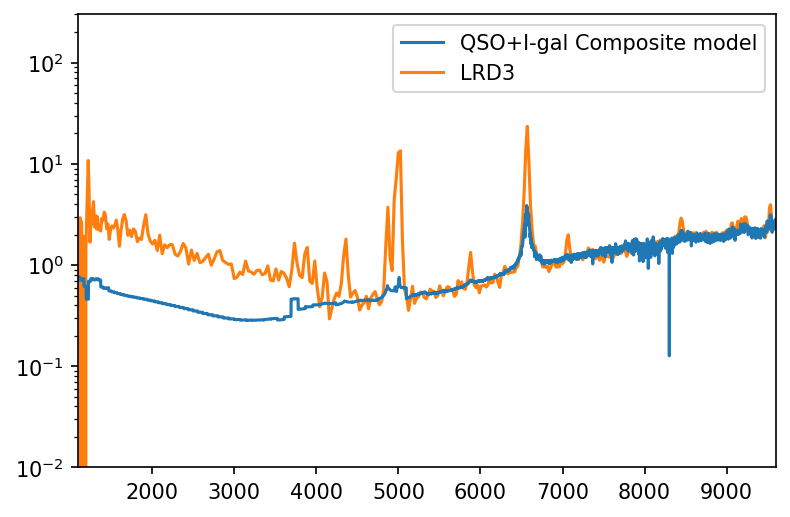

In [37]:
#select LRD
wave_lrd = wave_lrd3
spec_lrd = spec_lrd3

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]

#Read galaxy templates
tab = np.loadtxt('JaffetGaltemplates/lrt_templates.dat')
wave_jaffet = tab[:,0]*10000.
spec_E = tab[:,3]/wave_jaffet**2
spec_Sbc = tab[:,4]/wave_jaffet**2
spec_I = tab[:,5]/wave_jaffet**2

#Rebin to quasar wavelength grid
spec_I_rebin = spectres(wave_qso,wave_jaffet,spec_I)
spec_Sbc_rebin = spectres(wave_qso,wave_jaffet,spec_Sbc)
spec_E_rebin = spectres(wave_qso,wave_jaffet,spec_E)
spec_gal_rebin = spec_I_rebin


AVqso = 6
ABqso = AVqso*4.1/3.1

#Redden the qso template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model = 10**(-0.4*Alambda)*spec_qso

AVgal = 0
ABgal = AVgal*4.1/3.1

#Redden the gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABgal
spec_gal_rebin = 10**(-0.4*Alambda)*spec_gal_rebin

#Normalise
#specfilt = np.nonzero((wave_lrd > 4500) & (wave_lrd < 4600))
specfilt = np.nonzero((wave_lrd > 5250) & (wave_lrd < 5600))
normspec = np.mean(spec_lrd[specfilt])
#modelfilt = np.nonzero((wave_qso > 4500) & (wave_qso < 4600))
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model[modelfilt])
normgal = np.mean(spec_gal_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model = (2*model*factorqso+2*spec_gal_rebin*factorgal)/4.

#Make plot
plt.figure(dpi=150)
plt.plot(wave_qso,model,label='QSO+I-gal Composite model')
#plt.plot(wave_qso,spec_gal_rebin*factorgal, color='green')
plt.plot(wave_lrd,spec_lrd,zorder=1,label='LRD3')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
#plt.xlim(1200,12000) # LRD1
#plt.xlim(1200,8700) # LRD2
plt.xlim(1100,9600) #LRD3
plt.ylim(0.01,300)
plt.show()


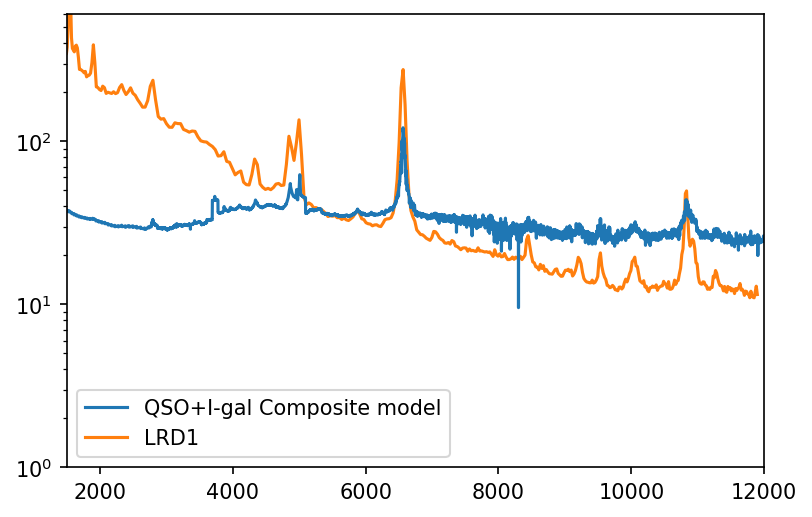

In [62]:
#select LRD
wave_lrd = wave_lrd1
spec_lrd = spec_lrd1

#Read quasar template
tab = np.loadtxt('compoM.data')
wave_qso = tab[:,0]
spec_qso = tab[:,1]

#Read galaxy templates
tab = np.loadtxt('JaffetGaltemplates/lrt_templates.dat')
wave_jaffet = tab[:,0]*10000.
spec_E = tab[:,3]/wave_jaffet**2
spec_Sbc = tab[:,4]/wave_jaffet**2
spec_I = tab[:,5]/wave_jaffet**2

#Rebin to quasar wavelength grid
spec_I_rebin = spectres(wave_qso,wave_jaffet,spec_I)
spec_Sbc_rebin = spectres(wave_qso,wave_jaffet,spec_Sbc)
spec_E_rebin = spectres(wave_qso,wave_jaffet,spec_E)
spec_gal_rebin = spec_I_rebin


AVqso = 2
ABqso = AVqso*4.1/3.1

#Redden the qso template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABqso
model = 10**(-0.4*Alambda)*spec_qso

AVgal = 0
ABgal = AVgal*4.1/3.1

#Redden the gal template
Alambda = spec_qso*0.
wlr = wave_qso/1.e4
for e in range(len(ai)):
    Alambda=Alambda+ai[e]/((wlr/wli[e])**ni[e]+(wli[e]/wlr)**ni[e]+bi[e])
Alambda = Alambda*ABgal
spec_gal_rebin = 10**(-0.4*Alambda)*spec_gal_rebin

#Normalise
#specfilt = np.nonzero((wave_lrd > 4500) & (wave_lrd < 4600))
specfilt = np.nonzero((wave_lrd > 5250) & (wave_lrd < 5600))
normspec = np.mean(spec_lrd[specfilt])
#modelfilt = np.nonzero((wave_qso > 4500) & (wave_qso < 4600))
modelfilt = np.nonzero((wave_qso > 5250) & (wave_qso < 5600))
normqso = np.mean(model[modelfilt])
normgal = np.mean(spec_gal_rebin[modelfilt])
factorqso = normspec/normqso
factorgal = normspec/normgal
model = (2*model*factorqso+2*spec_gal_rebin*factorgal)/4.

#Make plot
plt.figure(dpi=150)
plt.plot(wave_qso,model,label='QSO+I-gal Composite model')
#plt.plot(wave_qso,spec_gal_rebin*factorgal, color='green')
plt.plot(wave_lrd,spec_lrd,zorder=1,label='LRD1')
#plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlim(1500,12000) # LRD1
#plt.xlim(1200,8700) # LRD2
#plt.xlim(1100,9600) #LRD3
plt.ylim(1,600)
plt.show()
